<a href="https://colab.research.google.com/github/HalcyonForest/ARIMA/blob/main/TF_25_01_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [ ]:
sklearn.__version__

'0.22.2.post1'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SBER_190101_210108.csv to SBER_190101_210108.csv


In [ ]:
df = pd.read_csv('SBER_190101_210108.csv')
df['DATE'] = df['<DATE>']
df['TIME'] = df['<TIME>']
df['OPEN'] = df['<OPEN>']
df['HIGH'] = df['<HIGH>']
df['LOW'] = df['<LOW>']
df['CLOSE'] = df['<CLOSE>']
df['VOL'] = df['<VOL>']
df = df.drop(columns=['<DATE>', '<TIME>', '<OPEN>','<HIGH>','<LOW>','<CLOSE>', '<VOL>'])
df['DATETIME'] = df['DATE'].astype(str) + df['TIME'].astype(str)
df['DATETIME'].head()
time = pd.to_datetime(df['DATETIME'], format='%Y%m%d%H%M%S')
df.index = time
df = df.drop(columns=['DATE', 'TIME', 'DATETIME'])

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [ ]:
df_daily = df.resample("D").mean()
df_daily["OPEN"].fillna(method="ffill", inplace=True)
df_daily["CLOSE"].fillna(method="ffill", inplace=True)
df_daily["HIGH"].fillna(method="ffill", inplace=True)
df_daily["LOW"].fillna(method="ffill", inplace=True)
df_daily["VOL"].fillna(method="ffill", inplace=True)

In [ ]:
df_daily.shape

(737, 5)

In [ ]:
X, y = split_sequence(df_daily["CLOSE"], 30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X.shape

(707, 30)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train,y_train, epochs=1000, verbose=0)

In [ ]:
X_CNN = X.reshape(X.shape[0], X.shape[1], 1)
X_trainCNN, X_testCNN, y_trainCNN, y_testCNN = train_test_split(X_CNN, y, test_size=0.2, shuffle=False)


In [ ]:
model_CNN = Sequential()
model_CNN.add(Conv1D(64, 2, activation='relu', input_shape=(X.shape[1], 1)))
model_CNN.add(MaxPooling1D())
model_CNN.add(Flatten())
model_CNN.add(Dense(150, activation='relu'))
model_CNN.add(Dense(50, activation='relu'))
model_CNN.add(Dense(1))
model_CNN.compile(optimizer='adam', loss='mse')
model_CNN.fit(X_trainCNN,y_trainCNN, epochs=1000, verbose=0)
y_pred2 = model_CNN.predict(X_testCNN, verbose=0)

In [ ]:
print("Error CNN: ", mse(y_pred2, y_test))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
model_lstm.add(Dense(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
hi = model_lstm.fit(X_trainCNN, y_trainCNN, epochs=300, verbose=1, batch_size=15)
y_pred_lstm  = model_lstm.predict(X_testCNN, verbose=0)
print("Error: LSTM ", mse(y_pred_lstm, y_testCNN))


In [ ]:
print("Train Error, ", mse(model_lstm.predict(X_trainCNN, verbose=0), y_trainCNN))

Train Error,  16.3177529985986


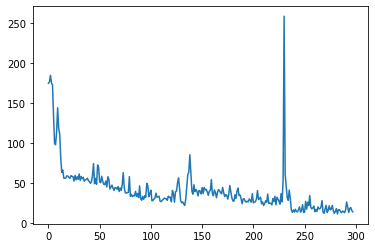

In [ ]:
plt.plot(hi.history['loss'][2:])

In [ ]:
model_lstm_b = Sequential()
model_lstm_b.add(Bidirectional(LSTM(50, activation='relu', input_shape=(X.shape[1], 1))))
model_lstm_b.add(Dense(150))
model_lstm_b.add(Dense(1))
model_lstm_b.compile(optimizer='adam', loss='mse')
model_lstm_b.fit(X_trainCNN, y_trainCNN, epochs=500, verbose=0)
y_pred_lstm_b  = model_lstm_b.predict(X_testCNN, verbose=0)
print("Error: LSTM Bidirectional:", mse(y_pred_lstm_b, y_testCNN))

Error: LSTM Bidirectional: 38.25124661745454


In [ ]:
model_lstm_s = Sequential()
model_lstm_s.add(LSTM(100, activation='relu', return_sequences=True ,input_shape=(X.shape[1], 1)))
model_lstm_s.add(LSTM(50, activation='relu'))
model_lstm_s.add(Dense(150))
model_lstm_s.add(Dense(1))
model_lstm_s.compile(optimizer='adam', loss='mse')
model_lstm_s.fit(X_trainCNN, y_trainCNN, epochs=500, verbose=0)
y_pred_lstm_s  = model_lstm_s.predict(X_testCNN, verbose=0)
print("Error: LSTM ", mse(y_pred_lstm_s, y_testCNN))

Error: LSTM  331.3170309635063


In [ ]:
X.shape

(707, 30)

In [ ]:
X_CNN_LSTM = X.reshape(X.shape[0],2, X.shape[1] // 2, 1)
X_trainCNN_LSTM, X_testCNN_LSTM, y_trainCNN_LSTM, y_testCNN_LSTM = train_test_split(X_CNN_LSTM, y, test_size=0.2, shuffle=False)

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(64, 1, activation='relu'), input_shape=(None, X.shape[1] // 2, 1)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(150))
model_cnn_lstm.add(Dense(50))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(optimizer='adam', loss='mse')
# fit model
model_cnn_lstm.fit(X_trainCNN_LSTM, y_trainCNN_LSTM, epochs=1000, verbose=0)
y_pred_cnn_lstm  = model_cnn_lstm.predict(X_testCNN_LSTM, verbose=0)
print("Error: CNN ^ LSTM ", mse(y_pred_cnn_lstm, y_testCNN_LSTM))

Error: CNN ^ LSTM  34.38358516104102


1.If the network has only one output node and you believe that the required input–output relationship is fairly straightforward, start with a hidden-layer dimensionality that is equal to two-thirds of the input dimensionality.

2.If you have multiple output nodes or you believe that the required input–output relationship is complex, make the hidden-layer dimensionality equal to the input dimensionality plus the output dimensionality (but keep it less than twice the input dimensionality).

3.If you believe that the required input–output relationship is extremely complex, set the hidden dimensionality to one less than twice the input dimensionality.

In [ ]:
from keras.callbacks import EarlyStopping
#Add Dropout!
#Увеличивать число нейронов а не слоев. Слоив помогают когда данных больше или фич.



EarlyStopping(monitor='val_err', patience=5)

In [ ]:
print(X_train.shape, y_train.shape)

(565, 30) (565,)


In [ ]:
boost = xgb.XGBRegressor()
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
         'max_depth':3, 
         'eta':0.3,  
         'seed':1,
         'eval_metric':'rmse'} # random parameters

steps = 20

boost.fit(X_train, y_train,eval_set=[(X_train, y_train)], verbose=0)

y_pred_xgb = boost.predict(X_test)
print("XGB Error: ", mse(y_pred_xgb, y_test))


[21:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Error:  62.481302852612416


Error CNN:  31.619856844692166
Error: LSTM  11.17651454730681
Error: Stacked LSTM  331.3170309635063


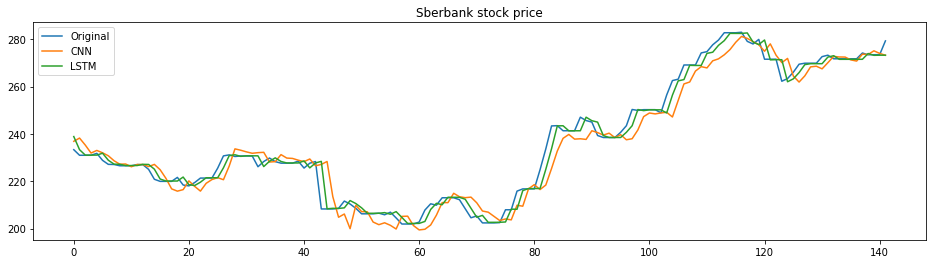

In [ ]:
y_pred = model.predict(X_test, verbose=0)
#print("Error mlp: ", mse(y_pred, y_test))
print("Error CNN: ", mse(y_pred2, y_test))
print("Error: LSTM ", mse(y_pred_lstm, y_testCNN))
print("Error: Stacked LSTM ", mse(y_pred_lstm_s, y_testCNN))
plt.figure(figsize=(16,4))
plt.plot(y_test)
#plt.plot(y_pred)
plt.plot(y_pred2)
plt.plot(y_pred_lstm)
plt.legend(['Original', 'CNN', 'LSTM','Stacked LSTM'])
plt.title('Sberbank stock price')
plt.show()


**2**. **Multistep** **forecasting**

In [ ]:
Xm, ym = split_sequence(df['CLOSE'], 60,6)

In [ ]:
df['CLOSE'].head(10)

DATETIME
2019-01-03 10:05:00    186.61
2019-01-03 10:10:00    186.20
2019-01-03 10:15:00    186.30
2019-01-03 10:20:00    186.38
2019-01-03 10:25:00    186.50
2019-01-03 10:30:00    188.14
2019-01-03 10:35:00    188.06
2019-01-03 10:40:00    188.30
2019-01-03 10:45:00    188.22
2019-01-03 10:50:00    188.18
Name: CLOSE, dtype: float64

In [ ]:
ym[:10]

array([[189.91, 189.59, 189.52, 189.36, 189.25, 189.36],
       [189.59, 189.52, 189.36, 189.25, 189.36, 189.43],
       [189.52, 189.36, 189.25, 189.36, 189.43, 189.66],
       [189.36, 189.25, 189.36, 189.43, 189.66, 189.54],
       [189.25, 189.36, 189.43, 189.66, 189.54, 189.17],
       [189.36, 189.43, 189.66, 189.54, 189.17, 189.05],
       [189.43, 189.66, 189.54, 189.17, 189.05, 188.99],
       [189.66, 189.54, 189.17, 189.05, 188.99, 189.27],
       [189.54, 189.17, 189.05, 188.99, 189.27, 189.44],
       [189.17, 189.05, 188.99, 189.27, 189.44, 189.35]])

In [ ]:
Xm[:10]

array([[186.61, 186.2 , 186.3 , 186.38, 186.5 , 188.14, 188.06, 188.3 ,
        188.22, 188.18, 188.7 , 188.52, 189.57, 190.11, 190.55, 190.11,
        190.36, 191.2 , 190.96, 190.43, 190.47, 190.29, 190.22, 190.29,
        190.5 , 190.44, 190.26, 190.31, 190.13, 190.07, 189.86, 189.8 ,
        189.98, 189.91, 189.52, 189.44, 189.24, 189.15, 189.42, 189.73,
        189.42, 189.41, 189.19, 189.18, 189.36, 189.63, 189.53, 189.67,
        189.56, 189.88, 189.43, 189.68, 189.52, 189.89, 189.67, 189.39,
        189.48, 189.47, 189.72, 189.7 ],
       [186.2 , 186.3 , 186.38, 186.5 , 188.14, 188.06, 188.3 , 188.22,
        188.18, 188.7 , 188.52, 189.57, 190.11, 190.55, 190.11, 190.36,
        191.2 , 190.96, 190.43, 190.47, 190.29, 190.22, 190.29, 190.5 ,
        190.44, 190.26, 190.31, 190.13, 190.07, 189.86, 189.8 , 189.98,
        189.91, 189.52, 189.44, 189.24, 189.15, 189.42, 189.73, 189.42,
        189.41, 189.19, 189.18, 189.36, 189.63, 189.53, 189.67, 189.56,
        189.88, 189.43,

In [ ]:
print(Xm.shape, ym.shape)

(60998, 60) (60998, 6)


In [ ]:
Xm_train,Xm_test,ym_train, ym_test = train_test_split(Xm, ym, test_size=0.3, shuffle=False) 

In [ ]:
print(Xm_train.shape, Xm_test.shape, ym_train.shape, ym_test.shape)

(48814, 40) (12204, 40) (48814, 6) (12204, 6)


In [ ]:
df['CLOSE'].head()

DATETIME
2019-01-03 10:05:00    186.61
2019-01-03 10:10:00    186.20
2019-01-03 10:15:00    186.30
2019-01-03 10:20:00    186.38
2019-01-03 10:25:00    186.50
Name: CLOSE, dtype: float64

In [ ]:
print(ym_test[:10])

[[226.18 226.1  226.19 225.73 225.5 ]
 [226.1  226.19 225.73 225.5  225.29]
 [226.19 225.73 225.5  225.29 225.2 ]
 [225.73 225.5  225.29 225.2  224.98]
 [225.5  225.29 225.2  224.98 225.05]
 [225.29 225.2  224.98 225.05 225.35]
 [225.2  224.98 225.05 225.35 225.29]
 [224.98 225.05 225.35 225.29 225.43]
 [225.05 225.35 225.29 225.43 224.86]
 [225.35 225.29 225.43 224.86 224.7 ]]


In [ ]:
print(ym_test[:10:3][:])

[[226.18 226.1  226.19 225.73 225.5 ]
 [225.29 225.2  224.98 225.05 225.35]]


In [ ]:
ym_test_plt = np.reshape(ym_test[::3], (-1))

In [ ]:
ym_test_plt[0]

226.6

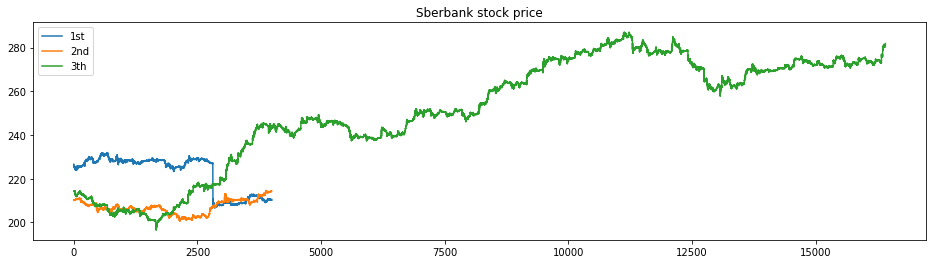

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(ym_test_plt[:4000])
plt.plot(ym_test_plt[4000:8000])
plt.plot(ym_test_plt[8000:])
plt.legend(['1st','2nd','3th'])
plt.title('Sberbank stock price')
plt.show()

 **Modeling:**






In [ ]:
n_steps_in = 60
n_steps_out = 6

In [ ]:
def error(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
  error = mse(y_pred, y_test)
  print(error)
  return error

In [ ]:
м# define model 200 0.55 300 0.50, 400 0.41 // 1000, 100: 0.37
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=n_steps_in))
# model.add(Dropout(0.1))
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# fit model
model.fit(Xm_train, ym_train, epochs=1000, verbose=1, validation_data=(Xm_test, ym_test))
err_mlp = error(Xm_test, ym_test, model)

NameError: ignored

In [ ]:
n_features = 1
Xmr_train = Xm_train.reshape((Xm_train.shape[0], Xm_train.shape[1], n_features))
Xmr_test = Xm_test.reshape((Xm_test.shape[0], Xm_test.shape[1], n_features))


In [ ]:
# define model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_cnn.add(MaxPooling1D())
model_cnn.add(Flatten())
model_cnn.add(Dense(20, activation='relu'))
model_cnn.add(Dense(n_steps_out))
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.fit(Xmr_train, ym_train, epochs=10, verbose=1)
err_cnn = error(Xmr_test, ym_test, model_cnn)


Epoch 1/10
1526/1526 [==============================] - 5s 3ms/step - loss: 754.1460
Epoch 2/10
1526/1526 [==============================] - 4s 3ms/step - loss: 2.0000
Epoch 3/10
1526/1526 [==============================] - 4s 3ms/step - loss: 2.1222
Epoch 4/10
1526/1526 [==============================] - 4s 3ms/step - loss: 3.3625
Epoch 5/10
1526/1526 [==============================] - 4s 3ms/step - loss: 2.0321
Epoch 6/10
1526/1526 [==============================] - 4s 3ms/step - loss: 2.3020
Epoch 7/10
1526/1526 [==============================] - 4s 3ms/step - loss: 1.5987
Epoch 8/10
1526/1526 [==============================] - 4s 3ms/step - loss: 1.4489
Epoch 9/10
1526/1526 [==============================] - 4s 3ms/step - loss: 1.5362
Epoch 10/10
1526/1526 [==============================] - 4s 3ms/step - loss: 1.4170
1.2397898497847193


In [ ]:
print(Xmr_test.shape, ym_test.shape)

(12205, 40, 1) (12205, 3)


In [ ]:
# define model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', return_sequences, input_shape=(n_steps_in,
n_features)))
model_lstm.add(Dense(n_steps_out))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(Xmr_train, ym_train, epochs=10, verbose=1)
err_lstm = error(Xmr_test, ym_test, model_lstm)


Epoch 1/10
1526/1526 [==============================] - 56s 35ms/step - loss: 28149.5076
Epoch 2/10
1526/1526 [==============================] - 55s 36ms/step - loss: 26.1210
Epoch 3/10
1526/1526 [==============================] - 54s 35ms/step - loss: 7.0518
Epoch 4/10
1526/1526 [==============================] - 55s 36ms/step - loss: 4.1430
Epoch 5/10
1526/1526 [==============================] - 54s 36ms/step - loss: 2.8589
Epoch 6/10
1526/1526 [==============================] - 55s 36ms/step - loss: 7290.0487
Epoch 7/10
1526/1526 [==============================] - 55s 36ms/step - loss: 9.4154
Epoch 8/10
1526/1526 [==============================] - 56s 36ms/step - loss: 13.1837
Epoch 9/10
1526/1526 [==============================] - 55s 36ms/step - loss: 9.2103
Epoch 10/10
1526/1526 [==============================] - 55s 36ms/step - loss: 6.7345
10.539681913416318


In [ ]:
# define model
model_ed = Sequential()
model_ed.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model_ed.add(RepeatVector(n_steps_out))
model_ed.add(LSTM(50, activation='relu', return_sequences=True))
model_ed.add(TimeDistributed(Dense(n_steps_out)))
model_ed.compile(optimizer='adam', loss='mse')
model_ed.fit(Xmr_train, ym_train, epochs=5, verbose=1)
err_ed = error(Xmr_test, ym_test, model_ed)

NameError: ignored

In [ ]:
# define model
model_ed2 = Sequential()
model_ed2.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model_ed2.add(RepeatVector(n_steps_out))
model_ed2.add(LSTM(50, activation='relu', return_sequences=True))
model_ed2.add(TimeDistributed(Dense(50)))
model_ed2.add(Dropout(0.2))
model_ed2.add(Dense(3))
model_ed2.compile(optimizer='adam', loss='mse')
model_ed2.fit(Xmr_train, ym_train, epochs=10, verbose=1)
err_ed2 = error(Xmr_test, ym_test, model_ed2)

Epoch 1/10
1526/1526 [==============================] - 51s 32ms/step - loss: 34170.7466
Epoch 2/10
1526/1526 [==============================] - 49s 32ms/step - loss: 8.0394
Epoch 3/10
1526/1526 [==============================] - 47s 31ms/step - loss: 5.3583
Epoch 4/10
1526/1526 [==============================] - 48s 31ms/step - loss: 4.8423
Epoch 5/10
1526/1526 [==============================] - 48s 31ms/step - loss: 5.1280
Epoch 6/10
1526/1526 [==============================] - 48s 32ms/step - loss: 5.5112
Epoch 7/10
1526/1526 [==============================] - 49s 32ms/step - loss: 9.7668
Epoch 8/10
1526/1526 [==============================] - 48s 32ms/step - loss: 5.3765
Epoch 9/10
1526/1526 [==============================] - 49s 32ms/step - loss: 5.9697
Epoch 10/10
1526/1526 [==============================] - 48s 32ms/step - loss: 5.5252
4.551816041966131


In [ ]:
y_pred_ed = model_ed.predict(Xmr_test)
print(y_pred_ed.shape, ym_test.shape)
er = mse(np.reshape(y_pred_ed, (y_pred_ed.shape[0], y_pred_ed.shape[1])), ym_test)
print(er)

(12205, 3, 1) (12205, 3)
57670.65789884065


In [ ]:
def y_to_plot(y):
  y = np.reshape(y[::3], (-1))
  return y

In [ ]:
y_pred1 = model.predict(Xm_test)
ym_test[:10]

array([[226.1 , 226.19, 225.73],
       [226.19, 225.73, 225.5 ],
       [225.73, 225.5 , 225.29],
       [225.5 , 225.29, 225.2 ],
       [225.29, 225.2 , 224.98],
       [225.2 , 224.98, 225.05],
       [224.98, 225.05, 225.35],
       [225.05, 225.35, 225.29],
       [225.35, 225.29, 225.43],
       [225.29, 225.43, 224.86]])

In [ ]:
ym_test[:10]

array([[226.1 , 226.19, 225.73],
       [226.19, 225.73, 225.5 ],
       [225.73, 225.5 , 225.29],
       [225.5 , 225.29, 225.2 ],
       [225.29, 225.2 , 224.98],
       [225.2 , 224.98, 225.05],
       [224.98, 225.05, 225.35],
       [225.05, 225.35, 225.29],
       [225.35, 225.29, 225.43],
       [225.29, 225.43, 224.86]])

In [ ]:
ym_test_plt = np.reshape(ym_test[::3], (-1))
ym_test_plt

array([226.1 , 226.19, 225.73, ..., 281.78, 282.24, 281.87])

In [ ]:
ym_pred_ed = model_ed.predict(Xmr_test)

In [ ]:
model, model_cnn, model_lstm, model_ed

In [ ]:
ym_pred_mlp = model.predict(Xm_test)
ym_pred_cnn = model_cnn.predict(Xm_CNN_test)
ym_pred_lstm = model_lstm.predict(Xmr_test)
ym_pred_ed = model_ed.predict(Xmr_test)


In [ ]:
original_plot = y_to_plot(ym_test)
mlp_plot = y_to_plot(ym_pred_mlp)
cnn_plot = y_to_plot(ym_pred_cnn)
lstm_plot = y_to_plot(ym_pred_lstm)
ed_plot = y_to_plot(ym_pred_ed)

In [ ]:
ym_pred_lstm = np.reshape(ym_pred_lstm, (ym_pred_lstm.shape[0], ym_pred_lstm.shape[1]))
ym_pred_ed = np.reshape(ym_pred_ed, (ym_pred_ed.shape[0], ym_pred_lstm.shape[1]))

In [ ]:
ym_pred_cnn.shape

(12204, 3)

In [ ]:
ym_test.shape

(12205, 3)

Error mlp:  13.826676875916036
Error CNN:  1.3540791566149852
Error: LSTM  10.539681913416318
Error: Encoder-Decoder LSTM  0.9510281790407946


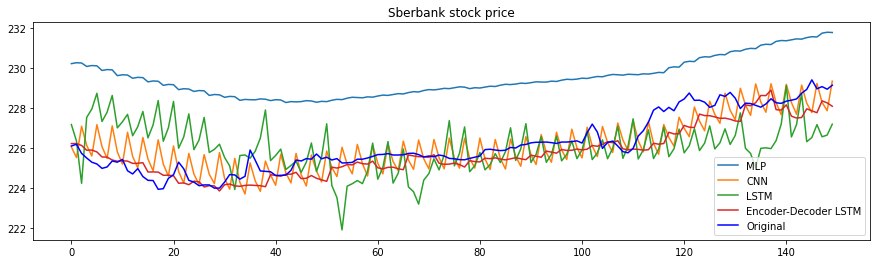

In [ ]:
# y_pred = model.predict(X_test, verbose=0)
print("Error mlp: ", mse(ym_pred_mlp, ym_test))
print("Error CNN: ", mse(ym_pred_cnn, ym_test[:-1]))
print("Error: LSTM ", mse(ym_pred_lstm, ym_test))
print("Error: Encoder-Decoder LSTM ", mse(ym_pred_ed, ym_test))
plt.figure(figsize=(15,4))

plt.plot(mlp_plot[:150])
plt.plot(cnn_plot[:150])
plt.plot(lstm_plot[:150])
plt.plot(ed_plot[:150])
plt.plot(original_plot[:150], 'b-')
plt.legend(['MLP', 'CNN', 'LSTM','Encoder-Decoder LSTM','Original'])
plt.title('Sberbank stock price')
plt.show()